# Cloud merge demo: NOAA ISD + GHCN
We'll read two datasets directly from the cloud and perform a simple merge using rounded lat/lon keys.

- ISD metadata (CSV): `https://noaa-isd-pds.s3.amazonaws.com/isd-history.csv`
- GHCN stations (fixed-width): `https://noaa-ghcn-pds.s3.amazonaws.com/ghcnd-stations.txt`

> For production work, use a spatial join or consistent IDs.


In [1]:
import pandas as pd, numpy as np, fsspec, re

# CHANGE THIS if you’re not using that station:
GHCN_URL = "s3://noaa-ghcn-pds/csv/by_station/USW00012918.csv"

with fsspec.open(GHCN_URL, anon=True) as f:
    g = pd.read_csv(f)

g.columns = [c.lower() for c in g.columns]
assert {"date","element","data_value"}.issubset(g.columns), g.columns.tolist()

def _parse_date(s):
    s = str(s)
    if re.fullmatch(r"\d{8}", s):     # e.g., 19700101
        return pd.to_datetime(s, format="%Y%m%d", errors="coerce")
    return pd.to_datetime(s, errors="coerce")

g["date"] = g["date"].apply(_parse_date)
pr = (g[g["element"]=="PRCP"][["date","data_value","q_flag"]]
        .rename(columns={"data_value":"prcp"}))
pr = pr[pr["date"].notna()]                       # keep valid dates
pr = pr[pr["q_flag"].isna()].drop(columns="q_flag", errors="ignore")
pr.loc[pr["prcp"] <= -9999, "prcp"] = np.nan      # missing flags
pr["prcp"] = pr["prcp"] / 10.0                    # tenths of mm → mm
pr = pr.sort_values("date").reset_index(drop=True)
pr["month"] = pr["date"].dt.to_period("M")
print(pr.head())


        date  prcp    month
0 1930-08-01  76.2  1930-08
1 1930-08-02   2.3  1930-08
2 1930-08-04   0.5  1930-08
3 1930-08-05   3.0  1930-08
4 1930-08-09   0.0  1930-08


In [2]:
import pandas as pd, numpy as np, requests, io

def load_noaa_oni_from_cpc(timeout=15) -> pd.DataFrame:
    # CPC Niño-3.4 (total, clim-adjusted, anomaly). We'll use ANOM and 3-mo centered mean = ONI.
    url = "https://www.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/detrend.nino34.ascii.txt"
    r = requests.get(url, headers={"User-Agent":"Mozilla/5.0"}, timeout=timeout)
    r.raise_for_status()

    df = pd.read_csv(
        io.StringIO(r.text),
        sep=r"\s+",
        header=None,
        names=["year","mon","total","clim","anom"],
        engine="python",
    )

    # keep valid year/month rows
    df = df[df["year"].astype(str).str.fullmatch(r"\d{4}", na=False)].copy()
    df["mon"]  = pd.to_numeric(df["mon"], errors="coerce")
    df = df[df["mon"].between(1,12, inclusive="both")].copy()
    df["anom"] = pd.to_numeric(df["anom"], errors="coerce")

    # build monthly timestamps
    ts = pd.to_datetime(dict(year=df["year"].astype(int), month=df["mon"].astype(int), day=1))
    df = df.assign(ts=ts).sort_values("ts").set_index("ts")

    # ONI = 3-month running mean (centered) of Niño-3.4 anomalies
    df["oni"] = df["anom"].rolling(3, center=True, min_periods=3).mean()

    out = df.reset_index(drop=False)
    out["month"] = out["ts"].dt.to_period("M")
    oni = (out.loc[:, ["month","oni"]]
              .dropna()
              .drop_duplicates()
              .sort_values("month")
              .reset_index(drop=True))
    return oni

# use it
oni = load_noaa_oni_from_cpc()
print("ONI months:", len(oni), "| range:", oni["month"].min(), "→", oni["month"].max())


ONI months: 907 | range: 1950-02 → 2025-08


Daily rows: 31356 | ONI NaN frac (daily): 0.127
Monthly rows: 1088 | range: 1930-08 → 2025-02
     month  prcp_mm_month  oni
0  1930-08          143.0  NaN
1  1930-09           66.5  NaN
2  1930-10          130.3  NaN
3  1930-11           64.3  NaN
4  1930-12          118.9  NaN


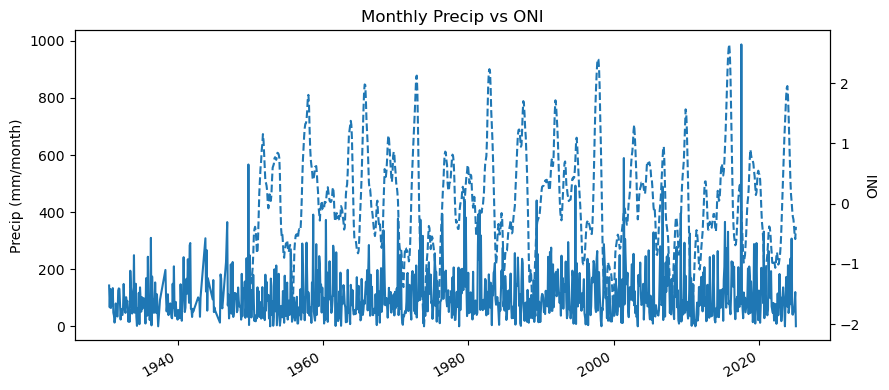

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- sanity: make sure required vars/cols exist ---
if "pr" not in globals() or "oni" not in globals():
    raise NameError("Expected DataFrames `pr` (daily precip) and `oni` (monthly ONI) to exist.")

need_pr_cols = {"date","prcp"}
need_oni_cols = {"month","oni"}
if not need_pr_cols.issubset(pr.columns):
    raise KeyError(f"`pr` must have columns {need_pr_cols}, found {set(pr.columns)}")
if not need_oni_cols.issubset(oni.columns):
    raise KeyError(f"`oni` must have columns {need_oni_cols}, found {set(oni.columns)}")

# --- ensure types/keys ---
pr2  = pr.copy()
pr2["date"]  = pd.to_datetime(pr2["date"], errors="coerce")
pr2           = pr2[pr2["date"].notna()].copy()
pr2["month"]  = pr2["date"].dt.to_period("M")

oni2 = oni.copy()
oni2["month"] = oni2["month"].astype("period[M]")

# --- merge ---
merged_daily = pr2.merge(oni2, on="month", how="left")

# --- monthly aggregate (sum precip, keep that month’s ONI) ---
monthly = (merged_daily
           .groupby("month", as_index=False)
           .agg(prcp_mm_month=("prcp","sum"),
                oni=("oni","first"))
           .sort_values("month")
           .reset_index(drop=True))

print("Daily rows:", len(merged_daily),
      "| ONI NaN frac (daily):", merged_daily["oni"].isna().mean().round(3))
print("Monthly rows:", len(monthly),
      "| range:", monthly["month"].min(), "→", monthly["month"].max())
print(monthly.head())

# --- plot (twin axes, works across matplotlib versions) ---
mts = monthly.set_index(monthly["month"].dt.to_timestamp())
fig, ax_left = plt.subplots(figsize=(9,4))
mts["prcp_mm_month"].plot(ax=ax_left)
ax_left.set_ylabel("Precip (mm/month)")
ax_left.set_xlabel("")
ax_left.set_title("Monthly Precip vs ONI")

ax_right = ax_left.twinx()
mts["oni"].plot(ax=ax_right, linestyle="--")
ax_right.set_ylabel("ONI")

plt.tight_layout()
plt.show()


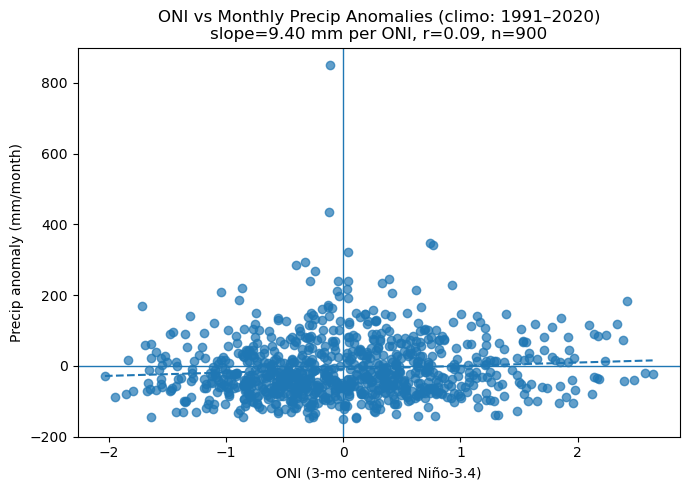

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assumes `monthly` has columns: ['month'(Period[M]), 'prcp_mm_month', 'oni']
if "monthly" not in globals():
    raise NameError("Need DataFrame `monthly` with columns ['month','prcp_mm_month','oni'].")

m = monthly.copy()

# Choose climatology base: 1991–2020 if covered, else use full record
base_start, base_end = pd.Period("1991-01"), pd.Period("2020-12")
if (m["month"].min() <= base_start) and (m["month"].max() >= base_end):
    base = m[(m["month"] >= base_start) & (m["month"] <= base_end)].copy()
    base_tag = "1991–2020"
else:
    base = m.copy()
    base_tag = "full period"

# Calendar-month climatology of monthly precip
m["moy"] = m["month"].dt.month
base["moy"] = base["month"].dt.month
clim = base.groupby("moy")["prcp_mm_month"].mean()

# Precip anomalies (mm/month)
m["prcp_anom"] = m["prcp_mm_month"] - m["moy"].map(clim)

# Drop rows without ONI or anomalies
plotdf = m.dropna(subset=["oni", "prcp_anom"]).copy()

# Linear fit (least squares)
x = plotdf["oni"].values
y = plotdf["prcp_anom"].values
if len(plotdf) < 3:
    raise ValueError("Not enough data after cleaning to plot/fill a regression.")
slope, intercept = np.polyfit(x, y, 1)
yfit = slope * x + intercept

# Pearson correlation
r = np.corrcoef(x, y)[0, 1]

# Scatter + regression line
fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(x, y, alpha=0.7)
# sort by x for a nice line
ordr = np.argsort(x)
ax.plot(x[ordr], yfit[ordr], linestyle="--")
ax.axhline(0, linewidth=1)
ax.axvline(0, linewidth=1)

ax.set_xlabel("ONI (3-mo centered Niño-3.4)")
ax.set_ylabel("Precip anomaly (mm/month)")
ax.set_title(f"ONI vs Monthly Precip Anomalies (climo: {base_tag})\n"
             f"slope={slope:.2f} mm per ONI, r={r:.2f}, n={len(plotdf)}")

plt.tight_layout()
plt.show()
